In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score,KFold
from imblearn.over_sampling import RandomOverSampler

In [210]:
df = pd.read_csv("BRCA Data.csv")
df.head(3)

,Patient_ID,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,TCGA-D8-A1XD,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,15-Jan-17,19-Jun-17,Alive
1,TCGA-EW-A1OX,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Positive,Positive,Negative,Lumpectomy,26-Apr-17,09-Nov-18,Dead
2,TCGA-A8-A079,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,08-Sep-17,09-Jun-18,Alive


In [211]:
df.shape

(341, 16)

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Patient_ID          334 non-null    object 
 1   Age                 334 non-null    float64
 2   Gender              334 non-null    object 
 3   Protein1            334 non-null    float64
 4   Protein2            334 non-null    float64
 5   Protein3            334 non-null    float64
 6   Protein4            334 non-null    float64
 7   Tumour_Stage        334 non-null    object 
 8   Histology           334 non-null    object 
 9   ER status           334 non-null    object 
 10  PR status           334 non-null    object 
 11  HER2 status         334 non-null    object 
 12  Surgery_type        334 non-null    object 
 13  Date_of_Surgery     334 non-null    object 
 14  Date_of_Last_Visit  317 non-null    object 
 15  Patient_Status      321 non-null    object 
dtypes: float

In [213]:
df.isnull().sum()

Patient_ID             7
Age                    7
Gender                 7
Protein1               7
Protein2               7
Protein3               7
Protein4               7
Tumour_Stage           7
Histology              7
ER status              7
PR status              7
HER2 status            7
Surgery_type           7
Date_of_Surgery        7
Date_of_Last_Visit    24
Patient_Status        20
dtype: int64

# Feature Engineering

In [214]:
df.dropna(inplace=True)

In [215]:
df.isnull().sum()

Patient_ID            0
Age                   0
Gender                0
Protein1              0
Protein2              0
Protein3              0
Protein4              0
Tumour_Stage          0
Histology             0
ER status             0
PR status             0
HER2 status           0
Surgery_type          0
Date_of_Surgery       0
Date_of_Last_Visit    0
Patient_Status        0
dtype: int64

In [216]:
for i in df.iloc[:,2:]:
    status = df[i].value_counts()
    fig = px.pie(values= status.values, names= status.index, hole= 0.5,title= i, width= 700,height= 400)
    fig.show()
    

* It seems PR status & ER status are biased 
* Target variable is imbalanced

In [217]:
df.columns

Index(['Patient_ID', 'Age', 'Gender', 'Protein1', 'Protein2', 'Protein3',
       'Protein4', 'Tumour_Stage', 'Histology', 'ER status', 'PR status',
       'HER2 status', 'Surgery_type', 'Date_of_Surgery', 'Date_of_Last_Visit',
       'Patient_Status'],
      dtype='object')

In [218]:
df.drop(['Patient_ID','ER status', 'PR status', 'Date_of_Surgery', 'Date_of_Last_Visit'],axis=1,inplace= True)
df.head(3)

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,Patient_Status
0,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,Alive
1,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Negative,Lumpectomy,Dead
2,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Negative,Other,Alive


# Encoding the categorical variables

In [219]:
encode = pd.get_dummies(df[['Gender','Tumour_Stage','Histology','HER2 status','Surgery_type','Patient_Status']],drop_first=True).astype(int)
encode.head(3)

,Gender_MALE,Tumour_Stage_II,Tumour_Stage_III,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,HER2 status_Positive,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy,Patient_Status_Dead
0,0,0,1,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0


In [220]:
data = pd.concat([df,encode],axis=1)
data.head(3)

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,...,Gender_MALE,Tumour_Stage_II,Tumour_Stage_III,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,HER2 status_Positive,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy,Patient_Status_Dead
0,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,...,0,0,1,0,0,0,1,0,0,0
1,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Negative,Lumpectomy,...,0,1,0,0,1,0,0,0,0,1
2,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Negative,Other,...,0,0,1,0,0,0,0,1,0,0


In [221]:
data.select_dtypes(include='object').columns

Index(['Gender', 'Tumour_Stage', 'Histology', 'HER2 status', 'Surgery_type',
       'Patient_Status'],
      dtype='object')

In [222]:
data.drop(data.select_dtypes(include='object').columns,axis=1,inplace=True)

In [223]:
data.head()

,Age,Protein1,Protein2,Protein3,Protein4,Gender_MALE,Tumour_Stage_II,Tumour_Stage_III,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,HER2 status_Positive,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy,Patient_Status_Dead
0,36.0,0.080353,0.42638,0.54715,0.273680,0,0,1,0,0,0,1,0,0,0
1,43.0,-0.420320,0.57807,0.61447,-0.031505,0,1,0,0,1,0,0,0,0,1
2,69.0,0.213980,1.31140,-0.32747,-0.234260,0,0,1,0,0,0,0,1,0,0
3,56.0,0.345090,-0.21147,-0.19304,0.124270,0,1,0,0,0,0,1,0,0,0
4,56.0,0.221550,1.90680,0.52045,-0.311990,0,1,0,0,0,0,0,1,0,1


In [224]:
data.shape

(317, 15)

# Balancing the imbalanced Target variable

In [225]:
ran = RandomOverSampler()
X,Y = ran.fit_resample(data.iloc[:,:-1],data['Patient_Status_Dead'])

In [226]:
X.shape

(510, 14)

In [227]:
Y.value_counts()

Patient_Status_Dead
0    255
1    255
Name: count, dtype: int64

* Target variable is in balanced now

# Scaling

In [228]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X[['Age','Protein1','Protein2','Protein3','Protein4']])
X_trans = pd.DataFrame(std.fit_transform(X[['Age','Protein1','Protein2','Protein3','Protein4']]),columns= ['Age','Protein1','Protein2','Protein3','Protein4'])


In [229]:
X_trans

,Age,Protein1,Protein2,Protein3,Protein4
0,-1.771949,0.254051,-0.624656,1.122685,0.376826
1,-1.227133,-0.728124,-0.450728,1.240958,-0.104850
2,0.796469,0.516189,0.390110,-0.413908,-0.424861
3,-0.215332,0.773389,-1.356016,-0.177732,0.141011
4,-0.215332,0.531039,1.072796,1.075777,-0.547543
...,...,...,...,...,...
505,-0.370994,0.949060,1.698153,0.748015,0.937648
506,0.095991,0.669634,0.922018,-0.003084,0.839840
507,-0.837979,-0.326915,-1.449934,1.685868,-0.437140
508,0.952130,0.793300,1.151224,0.137796,0.814145


In [230]:
xx = X.iloc[:,5:]

In [231]:
xx.shape

(510, 9)

In [232]:
X_trans.shape

(510, 5)

In [233]:
X_final = pd.concat([X_trans.reset_index(drop=True),
                     xx.reset_index(drop=True)], axis=1)


In [234]:
X_final.shape

(510, 14)

# Spliting the data for Training and Testing

In [31]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_final,Y,test_size=0.2,random_state=42)

# Model making sections
## 1.DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


## Hyperparameter Tunning

In [ ]:
dfir = { 'criterion': ["gini", "entropy", "log_loss"],
    'splitter':['best', 'random'],
    'max_depth':[i for i in range(2,20)]}

gd =GridSearchCV(DecisionTreeClassifier(),param_grid=dfir,cv=5)
gd.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'splitter': ['best', 'random']})

In [36]:
gd.best_params_

{'criterion': 'log_loss', 'max_depth': 17, 'splitter': 'random'}

In [37]:
gd.best_score_

0.8505871725383921

In [39]:
Dt = DecisionTreeClassifier(criterion='gini',max_depth = 19, splitter = 'best')
Dt.fit(x_train,y_train)
Dt.score(x_test,y_test) 
print(Dt.score(x_test,y_test))

0.8725490196078431


In [40]:
validation_D = cross_val_score(DecisionTreeClassifier(),x_train,y_train,cv=KFold(n_splits=10))
validation_D.mean()

0.8332926829268293

### Result

In [86]:
print(f'''DecisionTree:
    Validation Score: {validation_D.mean()}  
    Prediction Score: {Dt.score(x_test,y_test)}
    Diferrence: {(validation_D.mean()-(Dt.score(x_test,y_test)))}''')

DecisionTree:
    Validation Score: 0.8332926829268293  
    Prediction Score: 0.8725490196078431
    Diferrence: -0.039256336681013804


# 2.ExtraTrees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


## Hyperparameter Tunning

In [ ]:
lis = {'criterion':['gini','entropy'], 
        'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':[i for i in range(0,20)]}

fg = GridSearchCV(ExtraTreesClassifier(),param_grid= lis,cv=5)
fg.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'max_features': ['auto', 'sqrt', 'log2']})

In [45]:
fg.best_params_

{'criterion': 'gini', 'max_depth': 19, 'max_features': 'sqrt'}

In [46]:
fg.best_score_

0.9216199939777174

In [47]:
Et =(ExtraTreesClassifier(criterion = 'gini',max_depth = 16,max_features = 'log2'))
Et.fit(x_train,y_train)
Et.score(x_test,y_test)

0.9803921568627451

In [48]:
validation_E = cross_val_score(ExtraTreesClassifier(),x_train,y_train ,cv= KFold(n_splits=10))
validation_E

array([0.92682927, 0.97560976, 1.        , 0.87804878, 0.97560976,
       0.95121951, 0.95121951, 0.92682927, 0.95      , 0.925     ])

In [49]:
validation_E.mean()

0.9460365853658537

### Result

In [87]:
print(f'''ExtraTreesClassifier:
    Validation Score: {validation_E.mean()}  
    Prediction Score: {Et.score(x_test,y_test)}
    Diferrence: {(validation_E.mean()-(Et.score(x_test,y_test)))}''')

ExtraTreesClassifier:
    Validation Score: 0.9460365853658537  
    Prediction Score: 0.9803921568627451
    Diferrence: -0.03435557149689139


# 3.RandomForest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
Rf = RandomForestClassifier()
Rf.fit(x_train,y_train)
Rf.score(x_test,y_test)

0.9705882352941176

In [53]:

validation_R = cross_val_score(RandomForestClassifier(),x_train,y_train ,cv= KFold(n_splits=10))
validation_R

array([0.92682927, 1.        , 0.97560976, 0.92682927, 0.95121951,
       0.95121951, 0.97560976, 0.92682927, 0.95      , 0.9       ])

In [54]:
validation_R.mean()

0.9484146341463415

### Result

In [88]:
print(f'''RandomForestClassifier:
    Validation Score: {validation_R.mean()}  
    Prediction Score: {Rf.score(x_test,y_test)}
    Diferrence______: {(validation_R.mean()-(Rf.score(x_test,y_test)))}''')

RandomForestClassifier:
    Validation Score: 0.9484146341463415  
    Prediction Score: 0.9705882352941176
    Diferrence______: -0.022173601147776112


# 4.Support Vector Machine(SCV)

In [56]:
from sklearn.svm import SVC

In [57]:
svc_list = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf']} 

svc = GridSearchCV(SVC(), param_grid= svc_list, refit = True, verbose = 3) 
 
svc.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.512 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.506 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.506 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.512 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.506 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.506 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.512 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [58]:
svc.best_score_

0.9387533875338752

In [59]:
svc.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [60]:
sv= SVC(C=1,kernel='rbf',gamma=1)
sv.fit(x_train,y_train)
sv.score(x_test,y_test)

0.9803921568627451

In [61]:
validation_sv = cross_val_score(SVC(),x_train,y_train,cv=KFold(n_splits=10))
validation_sv.mean()

0.7278658536585365

### Result

In [89]:
print(f'''SVC:
    Validation Score: {validation_sv.mean()}  
    Prediction Score: {sv.score(x_test,y_test)}
    Diferrence______: {(validation_sv.mean()-(sv.score(x_test,y_test)))}''')

SVC:
    Validation Score: 0.7278658536585365  
    Prediction Score: 0.9803921568627451
    Diferrence______: -0.25252630320420855


# 5.K-Nearest Neighbors

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
knn_n = {
    'n_neighbors': [3,5,7,9,11,13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_h = GridSearchCV(KNeighborsClassifier(),param_grid= knn_n,cv= KFold(n_splits=10),scoring='accuracy')
knn_h.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [65]:
knn_h.best_score_

0.7989634146341464

In [66]:
knn_h.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [67]:
knn = KNeighborsClassifier(metric= 'manhattan',n_neighbors= 3, weights= 'distance')
knn.fit(x_train,y_train)
knn.score(x_test,y_test)

0.8235294117647058

In [68]:
validation_knn = cross_val_score(KNeighborsClassifier(),x_train,y_train,cv = KFold(n_splits=10),scoring = 'accuracy')
validation_knn.mean()

0.688780487804878

### Result

In [90]:
print(f'''K-NeighborsClassifier:
    Validation Score: {validation_knn.mean()}  
    Prediction Score: {knn.score(x_test,y_test)}
    Diferrence______: {(validation_knn.mean()-(knn.score(x_test,y_test)))}''')

K-NeighborsClassifier:
    Validation Score: 0.688780487804878  
    Prediction Score: 0.8235294117647058
    Diferrence______: -0.13474892395982785


# 6.XGBBoost

In [70]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [71]:

xgb_list = {
    'max_depth': [3,4,5],
    'learning_rate': [0.01,0.05,0.1],
    'n_estimators': [100,200],
    'subsample':[0.7,0.8,1],
    'colsample_bytree':[0.7,0.8,1]
}

xgb_ = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    param_grid=xgb_list,
    cv=5,
    scoring='accuracy'
)

xgb_.fit(x_train, y_train)
print(xgb_.best_params_)
print(xgb_.best_score_)

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}
0.8995784402288468


In [72]:
XGB = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42,colsample_bytree = 0.7,learning_rate = 0.1,max_depth = 5,
                        n_estimators = 200,subsample = 0.7)
XGB.fit(x_train,y_train)
XGB.score(x_test,y_test)

0.9117647058823529

In [73]:
validation_xgb = cross_val_score(xgb.XGBClassifier(),x_train,y_train,cv=KFold(n_splits=10),scoring= 'accuracy')
validation_xgb.mean()

0.9045121951219512

### Result

In [91]:
print(f'''XGBClassifier:
    Validation Score: {validation_xgb.mean()}  
    Prediction Score: {XGB.score(x_test,y_test)}
    Diferrence______: {(validation_xgb.mean()-(XGB.score(x_test,y_test)))}''')

XGBClassifier:
    Validation Score: 0.9045121951219512  
    Prediction Score: 0.9117647058823529
    Diferrence______: -0.007252510760401676


# Evulation Matrics

In [75]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

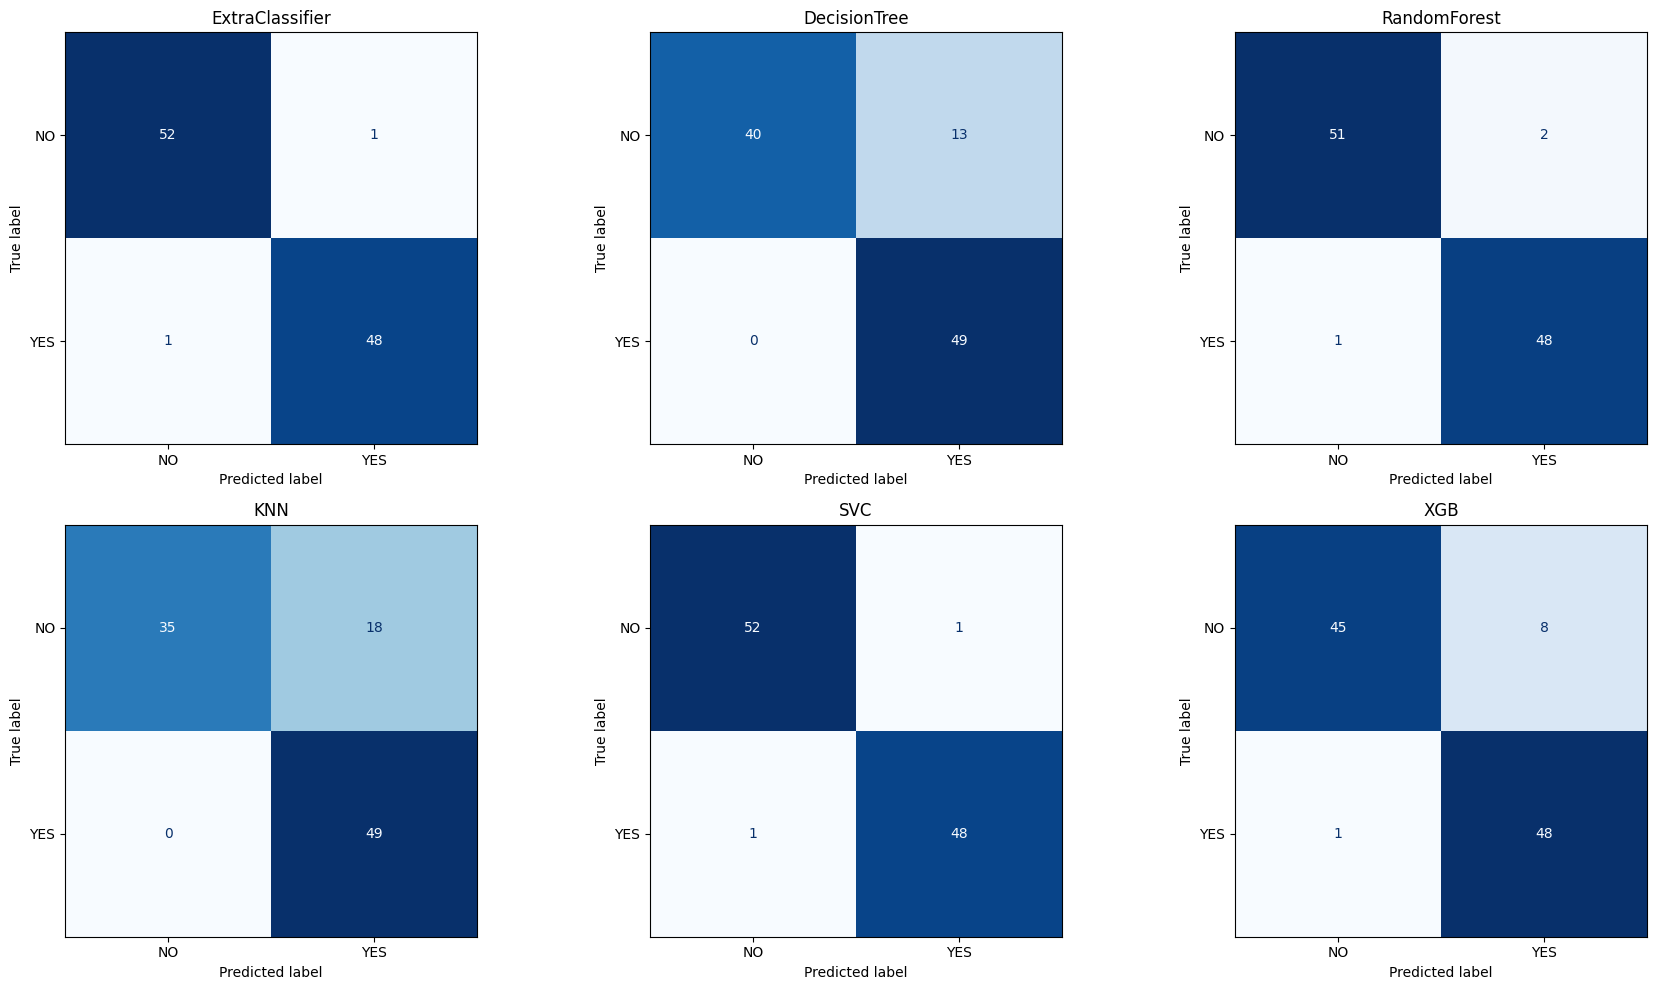

In [ ]:
plt.figure(figsize=(18, 10))

# 1st Row
ax1 = plt.subplot(2, 3, 1)
ConfusionMatrixDisplay.from_estimator(Et, x_test, y_test, display_labels=['NO','YES'], cmap='Blues', colorbar=False, ax=ax1)
plt.title('ExtraClassifier')

ax2 = plt.subplot(2, 3, 2)
ConfusionMatrixDisplay.from_estimator(Dt, x_test, y_test, display_labels=['NO','YES'], cmap='Blues', colorbar=False, ax=ax2)
plt.title('DecisionTree')

ax3 = plt.subplot(2, 3, 3)
ConfusionMatrixDisplay.from_estimator(Rf, x_test, y_test, display_labels=['NO','YES'], cmap='Blues', colorbar=False, ax=ax3)
plt.title('RandomForest')

# 2nd Row
ax4 = plt.subplot(2, 3, 4)
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=['NO','YES'], cmap='Blues', colorbar=False, ax=ax4)
plt.title('KNN')

ax5 = plt.subplot(2, 3, 5)
ConfusionMatrixDisplay.from_estimator(svc, x_test, y_test, display_labels=['NO','YES'], cmap='Blues', colorbar=False, ax=ax5)
plt.title('SVC')

ax6 = plt.subplot(2, 3, 6)
ConfusionMatrixDisplay.from_estimator(XGB, x_test, y_test, display_labels=['NO','YES'], cmap='Blues', colorbar=False, ax=ax6)
plt.title('XGB')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd


models = {
    "ExtraTrees": Et,
    "DecisionTree": Dt,
    "RandomForest": Rf,
    "KNN": knn,
    "SVC": svc,
    "XGB": XGB
}

results = []


for name, model in models.items():
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1-score": round(f1, 3)
    })


df_metrics = pd.DataFrame(results)


In [78]:
df_metrics['Cross-Validation'] = [round(validation_E.mean(),2),round(validation_D.mean(),2),round(validation_R.mean(),2),
                            round(validation_knn.mean(),2),round(validation_sv.mean(),2),round(validation_xgb.mean(),2)]

In [79]:

df_metrics.sort_values(by="F1-score", ascending=False).style

,Model,Accuracy,Precision,Recall,F1-score,Cross-Validation
0,ExtraTrees,0.980000,0.980000,0.980000,0.980000,0.950000
4,SVC,0.980000,0.980000,0.980000,0.980000,0.730000
2,RandomForest,0.971000,0.960000,0.980000,0.970000,0.950000
5,XGB,0.912000,0.857000,0.980000,0.914000,0.900000
1,DecisionTree,0.873000,0.790000,1.000000,0.883000,0.830000
3,KNN,0.824000,0.731000,1.000000,0.845000,0.690000


* Evulation Table

# ROC-AUC Curve

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [ ]:
models = {
    "ExtraTrees": Et,
    "DecisionTree": Dt,
    "RandomForest": Rf,
    "KNN": knn,
    "SVC": svc,
    "XGB": XGB
}

roc_data = {}

for name, model in models.items():
    # Some models (like SVC) require probability=True to use predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(x_test)[:,1]  
    else:  
        y_prob = model.decision_function(x_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)


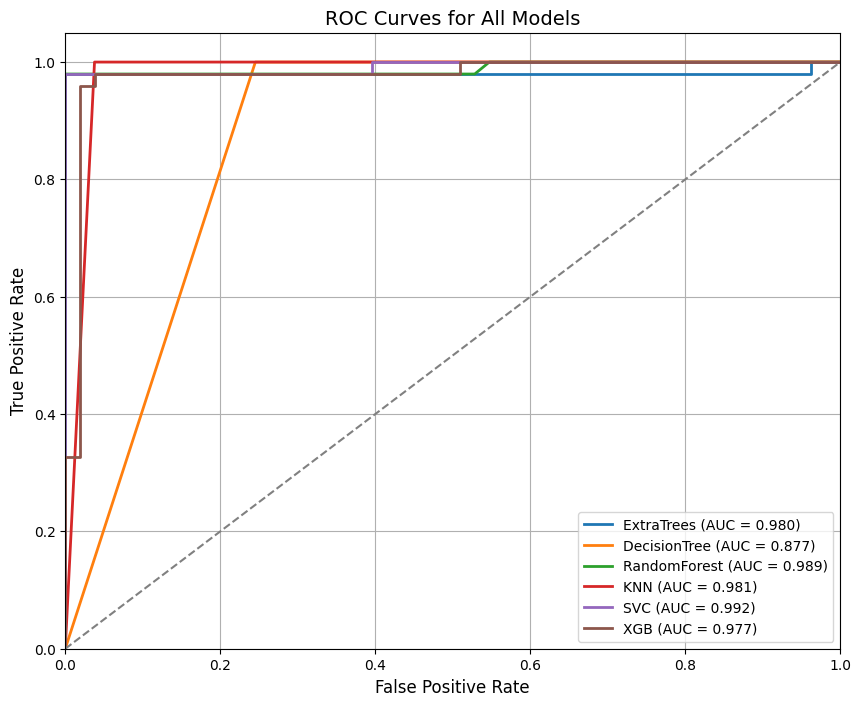

In [ ]:
plt.figure(figsize=(10, 8))

for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0,1], [0,1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for All Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Feature Importance for ExtraTrees

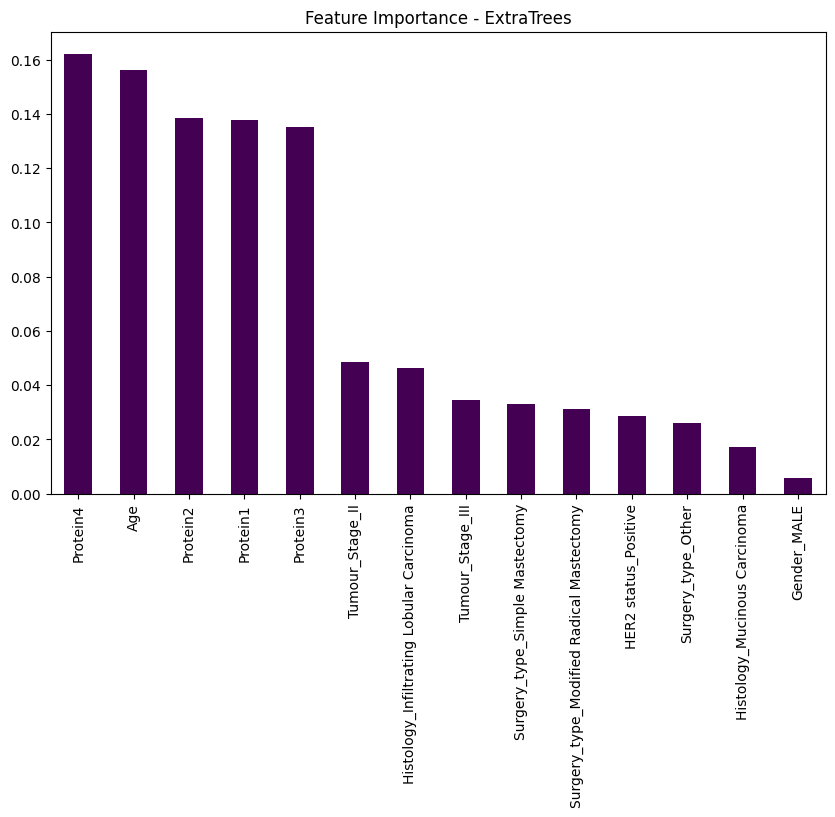

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

importances = Et.feature_importances_
features = X.columns 

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar',colormap ='viridis')
plt.title("Feature Importance - ExtraTrees")
plt.show()
